In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [70]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.CenterCrop(16),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

#torchvision.transforms.Normalize(
#                                 (0.1307,), (0.3081,))

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.CenterCrop(16),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [71]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 16, 16])

In [85]:
print(example_data[1][0])
print(example_data[1][0].view(-1,16*16))

tensor([[0.0000, 0.0000, 0.1216, 0.9961, 0.9961, 0.9961, 0.8275, 0.5373, 0.2353,
         0.2588, 0.3059, 0.3647, 0.9255, 0.9961, 0.1529, 0.0000],
        [0.0000, 0.0000, 0.3255, 0.9373, 0.9529, 0.3412, 0.0353, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2039, 0.9765, 0.9961, 0.1529, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2314, 0.5608, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.5373, 0.9961, 0.9961, 0.1529, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1490, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2824, 0.9686, 0.9961, 0.7686, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314, 0.3176,
         0.6392, 0.9490, 0.9961, 0.7882, 0.1176, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2157, 0.6627, 0.8078, 0.9961,
         0.9961, 0.9961, 0.5020, 0.0706, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0627, 0.3922, 0.7137, 0.9725, 0.9961, 0.9961, 0.9961,
         0.9647, 0.2392, 0.0078, 0.00

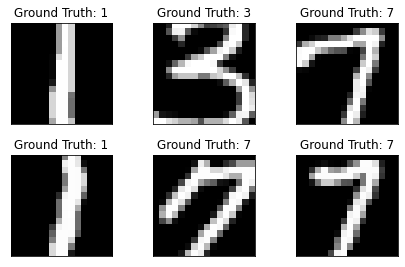

In [73]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [74]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [75]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc1 = nn.Linear(28*28, 16)
        self.fc1 = nn.Linear(16*16, 8)
        #self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(8, 10)

    def forward(self, x):
        x = x.view(-1,16*16)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [76]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [77]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [78]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')

In [79]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [80]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-75-759eb957afec>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3044, Accuracy: 1026/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302891
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.276080
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.259257
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.171908
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.185268
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.147006
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.147059
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.120481
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.081856
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.058672
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.007342
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.878817
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.961772
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.912954
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.883357
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.846833
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.788921
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.737892
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.768675
Train Epoch: 1 [12160

Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.439598
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.583649
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.406069
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.721526
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.306652
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.501873
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.410244
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.332454
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.469315
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.483052
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.414115
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.480142
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.398562
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.375994
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.381603
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.625006
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.406063
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.376790
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.616333
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.541635


In [83]:
# print model's state_dict
print("model's state_dict")
for param_tensor in network.state_dict():
    print(param_tensor, "\t", network.state_dict()[param_tensor].size())
    print(network.state_dict()[param_tensor])

model's state_dict
fc1.weight 	 torch.Size([8, 256])
tensor([[-0.0750, -0.0864,  0.0200,  ...,  0.0126, -0.0171, -0.0083],
        [-0.0105,  0.0675,  0.0530,  ..., -0.0964, -0.0156, -0.0819],
        [ 0.0347,  0.0950,  0.0809,  ...,  0.0281,  0.0156,  0.0101],
        ...,
        [-0.0342, -0.0426,  0.0154,  ...,  0.0160, -0.0199,  0.0270],
        [-0.0257, -0.0244, -0.0827,  ..., -0.1327, -0.0809, -0.0575],
        [-0.0082,  0.0426,  0.0732,  ...,  0.2371,  0.2198,  0.1919]])
fc1.bias 	 torch.Size([8])
tensor([ 0.0744,  0.3271,  0.1280, -0.0017,  0.0862,  0.2383,  0.3004, -0.0264])
fc3.weight 	 torch.Size([10, 8])
tensor([[ 0.3617,  0.4666, -0.3948,  0.9874,  0.0338, -0.3331, -0.6225, -0.7126],
        [-0.3090, -0.4924, -0.5181, -0.6964,  0.3236, -0.9086,  1.0841,  0.6538],
        [-0.6108, -0.5017, -0.0206,  0.8811, -0.4824, -0.0380, -0.2598,  1.0144],
        [-0.0817,  0.7145,  0.7064, -0.2310, -0.9158, -0.7503, -0.2806,  0.6598],
        [-0.1369, -0.6426,  0.9510, -0.5191,

## TODO: store the test data in .txt file; store the parameters in .txt file

### Already get network.state_dict(), containing all parameters.
### Already get test_loader, can print test data in (1,256) (like example_data)